In [21]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
import itertools


In [22]:
df = pd.read_csv('exchange_rate.csv')

# Convert 'Date' to datetime
df['date'] = pd.to_datetime(df['date'],dayfirst=True,errors='coerce')

# Sort by date
df = df.sort_values('date')

# Remove duplicates
df = df.drop_duplicates(subset='date')
df=df.dropna(subset=['date'])
# Handle missing values
df['Ex_rate'] = df['Ex_rate'].interpolate(method='linear')

# Set Date as index
df.set_index('date', inplace=True)

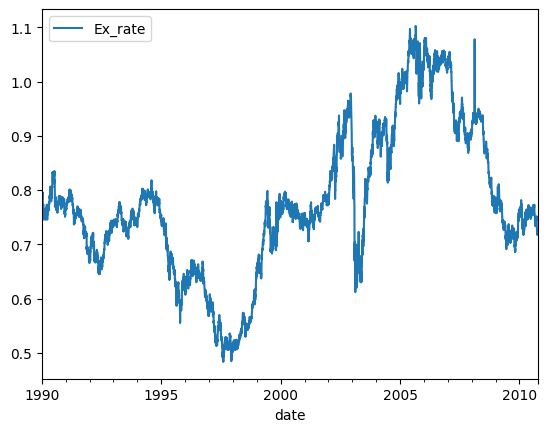

In [23]:
df.plot()
plt.show()

array([[<Axes: title={'center': 'Ex_rate'}>]], dtype=object)

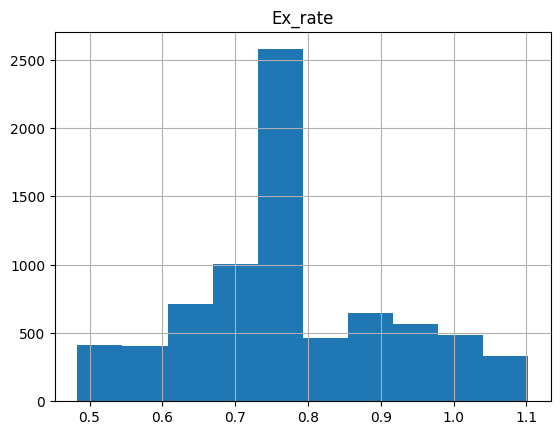

In [24]:
df.hist()

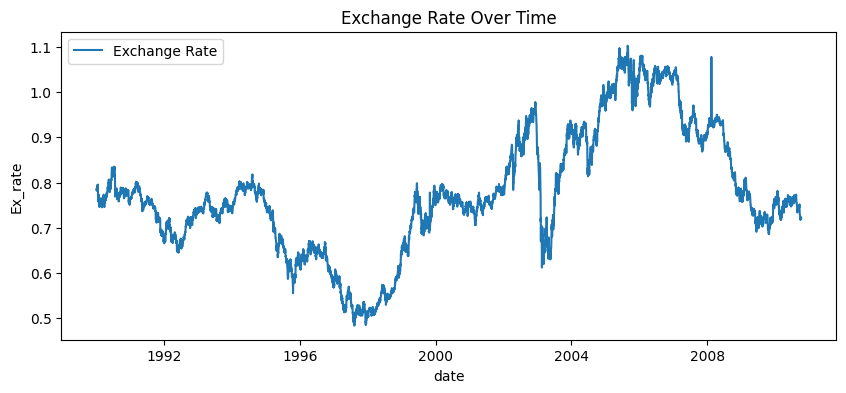

In [25]:
plt.figure(figsize=(10, 4))
plt.plot(df['Ex_rate'], label='Exchange Rate')
plt.title('Exchange Rate Over Time')
plt.xlabel('date')
plt.ylabel('Ex_rate')
plt.legend()
plt.show()

In [26]:
#Check for stationarity (ADF Test)

result = adfuller(df['Ex_rate'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

if result[1] > 0.05:
    print("Series is non-stationary — differencing required.")
else:
    print("Series is stationary.")

# If non-stationary, apply first differencing
df_diff = df['Ex_rate'].diff().dropna()

ADF Statistic: -1.6649941807382342
p-value: 0.4492327353597477
Series is non-stationary — differencing required.


In [27]:
# Split data into train & test

train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]


In [28]:
#  ARIMA parameter tuning (grid search)

p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))

best_score, best_params = float("inf"), None

for param in pdq:
    try:
        model = ARIMA(train['Ex_rate'], order=param)
        model_fit = model.fit()
        aic = model_fit.aic
        if aic < best_score:
            best_score, best_params = aic, param
    except:
        continue

print(f"Best ARIMA parameters: {best_params}")


Best ARIMA parameters: (1, 1, 1)


In [29]:
# Fit final ARIMA model

model = ARIMA(train['Ex_rate'], order=best_params)
model_fit = model.fit()

# Forecast
forecast = model_fit.forecast(steps=len(test))


In [30]:
# Evaluate model performance

rmse = sqrt(mean_squared_error(test['Ex_rate'], forecast))
print(f"RMSE: {rmse:.4f}")

RMSE: 0.2054


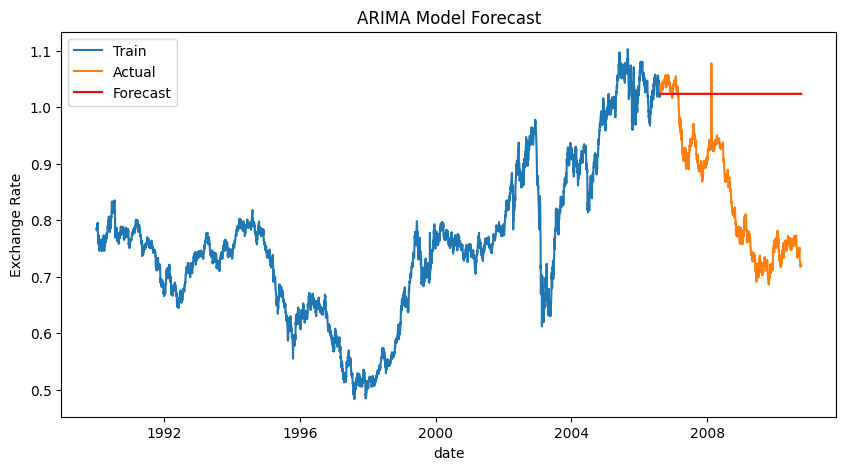

In [31]:
# Plot actual vs predicted

plt.figure(figsize=(10, 5))
plt.plot(train.index, train['Ex_rate'], label='Train')
plt.plot(test.index, test['Ex_rate'], label='Actual')
plt.plot(test.index, forecast, label='Forecast', color='red')
plt.title('ARIMA Model Forecast')
plt.xlabel('date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

In [32]:
# separate out a validation dataset
split_point = len(df) - 10
dataset, validation = df[0:split_point], df[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('dataset.csv', header=False)
validation.to_csv('validation.csv', header=False)

Dataset 7578, Validation 10


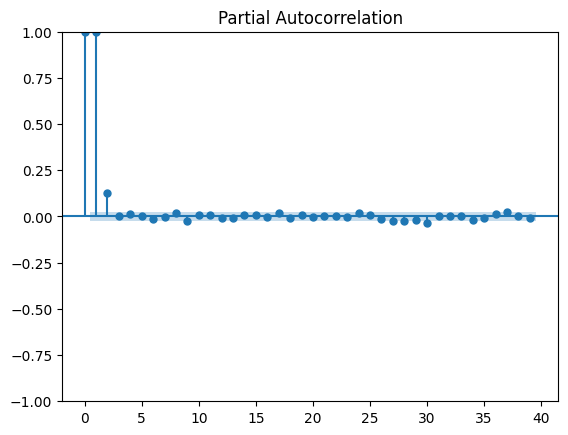

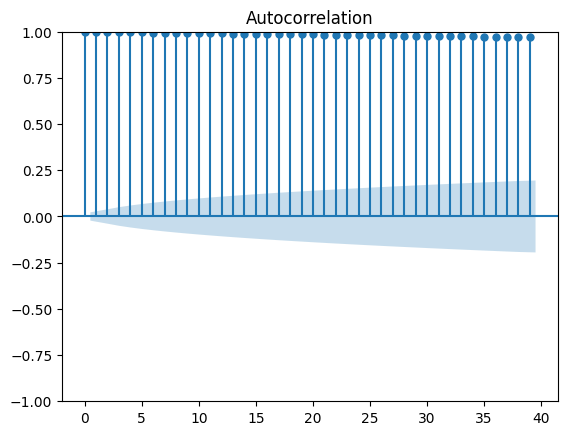

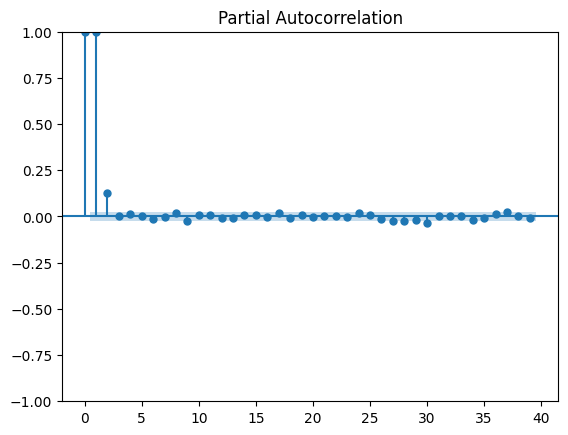

In [33]:
#ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(df['Ex_rate'])
plot_pacf(df['Ex_rate'])